In [106]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt

DATASET_PATH = './dataset/500/'
NUM_EPOCHS = 50
SEED = 42
NUM_SAMPLES_20000 = True
DEBUG = True

def debug_print(message):
    if DEBUG:
        print(message)

synthetic_data_files = os.listdir(DATASET_PATH)
data_files = [file for file in synthetic_data_files if file.startswith('A') and '000500s' in file]
print(f"Len of datafiles: {len(data_files)}")

Len of datafiles: 288


## Prepare dataset

In [107]:
functional_labels = ['ELF', 'ELL', 'ELT', 'FLF', 'FLL', 'FLT']
data_matrices = {}
labels = {}

for file in data_files:
    file_path = os.path.join(DATASET_PATH, file)
    molecule_name = file.split('s')[1]
    data_matrix = pd.read_csv(file_path, header=None).values
    data_matrices[molecule_name] = data_matrix.flatten()  # flattening the data matrix
    labels[molecule_name] = 1 if any(label in molecule_name for label in functional_labels) else 0

all_data = np.array(list(data_matrices.values()))
all_labels = np.array(list(labels.values()))

X_train, X_test, y_train, y_test = train_test_split(
    all_data, all_labels, test_size=0.3, stratify=all_labels, random_state=SEED
)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print("Train: ", X_train.shape)
print("Test: ", X_test.shape)

Train:  (201, 29000)
Test:  (87, 29000)


# Logistic Regression Model

In [108]:
from keras.regularizers import l2
# Logistic Regression Model
model = Sequential()
# Dense implements the operation: output = activation(dot(input, kernel) + bias)
# Ref: https://keras.io/api/layers/core_layers/dense/

model.add(Dense(1, # Output
                activation='sigmoid', # Binary classification
                input_shape=(X_train.shape[1],),
                kernel_regularizer=l2(0.1) # L2 regularization factor
                ))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy']
              )

model.summary()

history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=64, validation_data=(X_test, y_test), verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy:.3f}")

Model: "sequential_30"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 1)                 29001     
                                                                 
Total params: 29,001
Trainable params: 29,001
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4/4 [==============================] - 0s 22ms/step - loss: 0.8931 - accuracy: 0.5672 - val_loss: 0.7230 - val_accuracy: 0.7701
Epoch 2/50
4/4 [==============================] - 0s 6ms/step - loss: 0.6182 - accuracy: 0.8060 - val_loss: 0.6335 - val_accuracy: 0.8276
Epoch 3/50
4/4 [==============================] - 0s 6ms/step - loss: 0.5438 - accuracy: 0.8657 - val_loss: 0.5707 - val_accuracy: 0.8161
Epoch 4/50
4/4 [==============================] - 0s 7ms/step - loss: 0.5068 - accuracy: 0.8955 - val_loss: 0.5214 - val_accuracy: 0.8506
Epoch 5/50
4/4 [==============================]

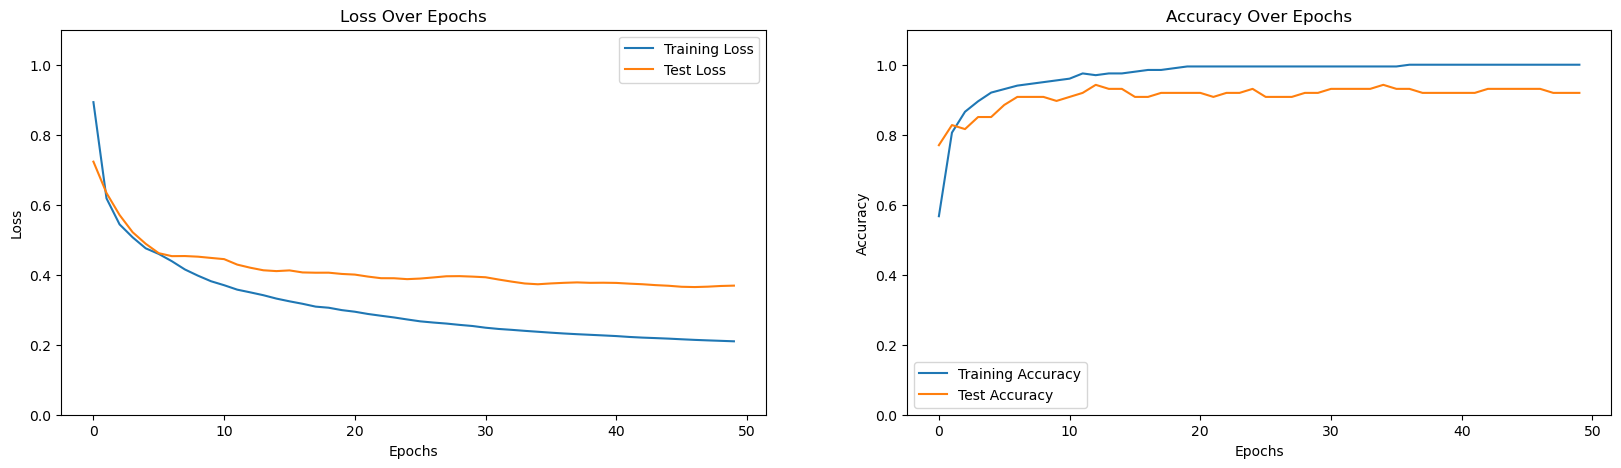

In [111]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 1.1])
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1.1])
plt.legend()

plt.show()